In [1]:
import ROOT as r 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


Welcome to JupyROOT 6.24/02


In [2]:
directory= "/Users/adit/Google Drive/Internship_ Research/Muon g-2/Data Filed/combined_forAdit_timealigned.root"
f = r.TFile(directory)

In [3]:
f.cd('LaserEvents')
t = f.Get('LaserEvents/tree')
df = pd.DataFrame(r.RDataFrame(t).AsNumpy())
c= r.TCanvas()

In [5]:
import random
random.seed(100)

#runs = pd.unique(df['runNum'])
#subRuns = pd.unique(df[df['runNum'] == run]['subRunNum'])
#fillNums = pd.unique(df[(df['runNum'] == run) & (df['subRunNum']==subRun)]['fillNum'])
#calos = pd.unique(df['caloNum'])
#xtals = pd.unique(df['xtalNum'])

#run = random.choice(runs)
#subRun = random.choice(subRuns)
#fill = random.choice(fillNums)
#calo = random.choice(calos)
#xtal = random.choice(xtals)

run = 25032
subRun = 173
fill = 12
calo = 2
xtal =10


In [66]:
run = 25032
subRun = 173
fill = 12
calo = 2
xtal =10

In [6]:
print(df.describe())
print(df.nunique())
print(df.head())

       gpsTimeStamp  cccTimeStamp        runNum     subRunNum       fillNum  \
count  3.779552e+07  3.779552e+07  3.779552e+07  3.779552e+07  3.779552e+07   
mean   1.555790e+09  9.911910e+10  2.496101e+04  2.245266e+02  1.342963e+02   
std    2.544310e+05  5.867342e+10  8.201021e+01  1.350690e+02  7.734417e+01   
min    1.554982e+09  2.163583e+08  2.468500e+04  0.000000e+00  1.000000e+00   
25%    1.555664e+09  4.969637e+10  2.492800e+04  1.090000e+02  6.600000e+01   
50%    1.556000e+09  9.647675e+10  2.502600e+04  2.150000e+02  1.370000e+02   
75%    1.556003e+09  1.477690e+11  2.502600e+04  3.380000e+02  1.960000e+02   
max    1.556034e+09  2.220666e+11  2.503200e+04  4.930000e+02  3.770000e+02   

           bunchNum    fillType       caloNum       xtalNum      sipmTime  \
count  3.779552e+07  37795516.0  3.779552e+07  3.779552e+07  3.779552e+07   
mean   7.500986e+00         1.0  1.249642e+01  2.651775e+01  1.989889e+05   
std    4.609085e+00         0.0  6.923995e+00  1.557810e+

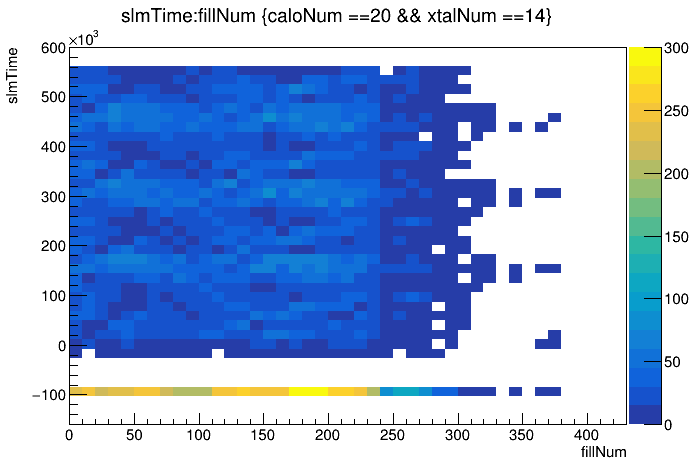

In [6]:
t.Draw('slmTime:fillNum', "caloNum =={} && xtalNum =={}".format(calo,xtal), 'colz')
c.Draw()
c.SetLogy(0)


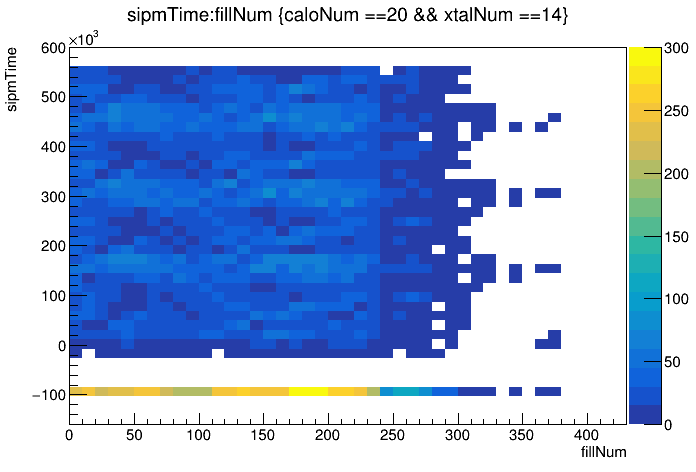

In [7]:
t.Draw('sipmTime:fillNum', "caloNum =={} && xtalNum =={}".format(calo,xtal), 'colz')
c.Draw()
c.SetLogy(0)


In [6]:
df_filtered = df.loc[(df['sipmTime']-df['slmTime']) < 50]
df_noise = df.loc[(df['sipmTime']-df['slmTime']) > 50]
#evaluated this in a diff notebook, nothing significant, no commonalities, only 47 of 29k entries per calo



In [7]:
df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
syncPulse = df_xtal[df_xtal['slmTime']< -10000][['runNum','subRunNum','fillNum', 'slmEnergy']]
laserPulse = df_xtal[df_xtal['slmTime']> -10000]

In [8]:
syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
laserPulse  = pd.merge(laserPulse,syncPulse, how = 'inner', on = ['runNum','subRunNum','fillNum'])
laserPulse['normalSlmEnergy'] = (laserPulse['slmEnergy']/laserPulse['syncEnergy'])

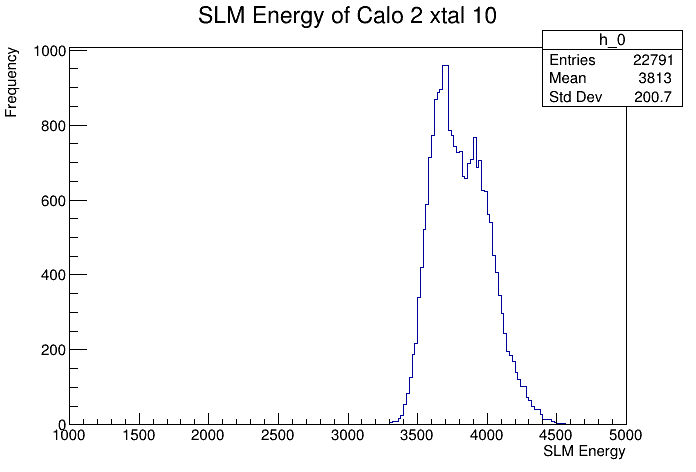

In [11]:
h0 = r.TH1D(f"h_{0}", "SLM Energy of Calo {} xtal {}; SLM Energy; Frequency".format(calo,xtal), 200, 1000, 5000)

for x in laserPulse['slmEnergy']:
    h0.Fill(x)

h0.Draw()
c.Draw()


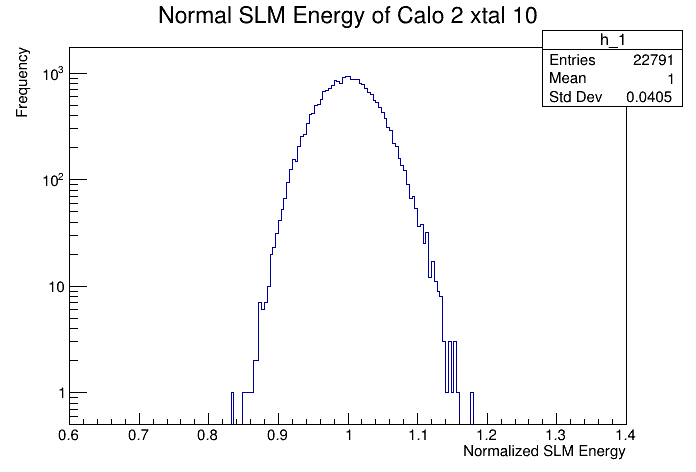

In [12]:
c.SetLogy()

h1 = r.TH1D(f"h_{1}", "Normal SLM Energy of Calo {} xtal {}; Normalized SLM Energy; Frequency".format(calo,xtal), 200, 0.6, 1.4)

for x in laserPulse['normalSlmEnergy']:
    h1.Fill(x)

h1.Draw()
c.Draw()

#see a spike at 1, probably because of a large proportion of sync Pulses

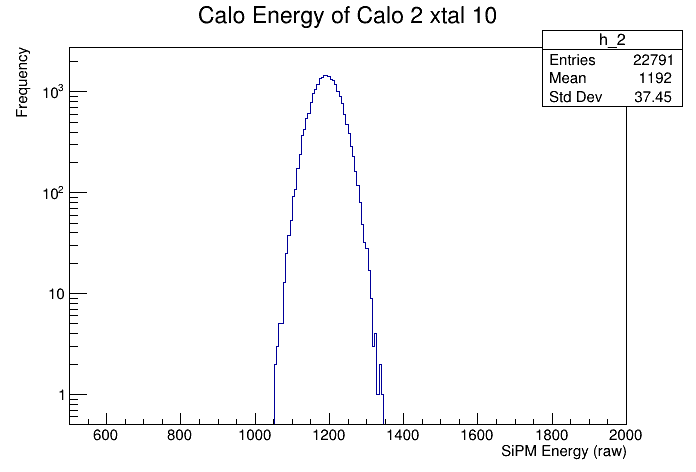

In [13]:
h2 = r.TH1D(f"h_{2}", "Calo Energy of Calo {} xtal {}; SiPM Energy (raw); Frequency".format(calo,xtal), 250, 500, 2000)

for x in laserPulse['sipmEnergy']:
    h2.Fill(x)

h2.Draw()
c.Draw()



Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_3 (Potential memory leak).


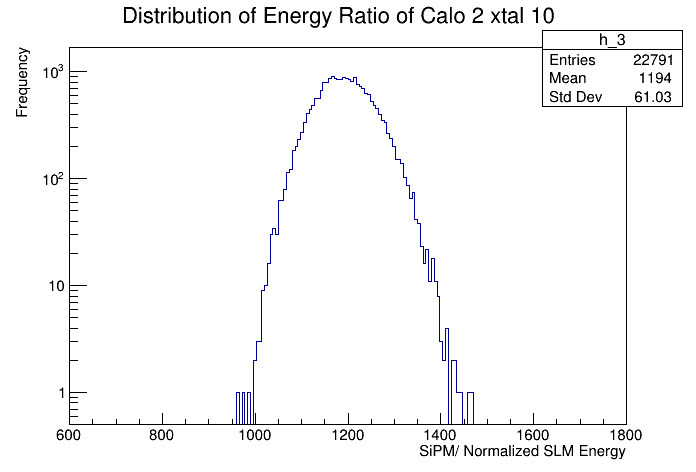

In [14]:
h3 = r.TH1D(f"h_{3}", "Distribution of Energy Ratio of Calo {} xtal {}; SiPM/ Normalized SLM Energy; Frequency".format(calo,xtal), 200, 600, 1800)

for x in laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']:
    h3.Fill(x)

h3.Draw()
c.Draw()

mean_temp = h3.GetMean()

Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_100 (Potential memory leak).


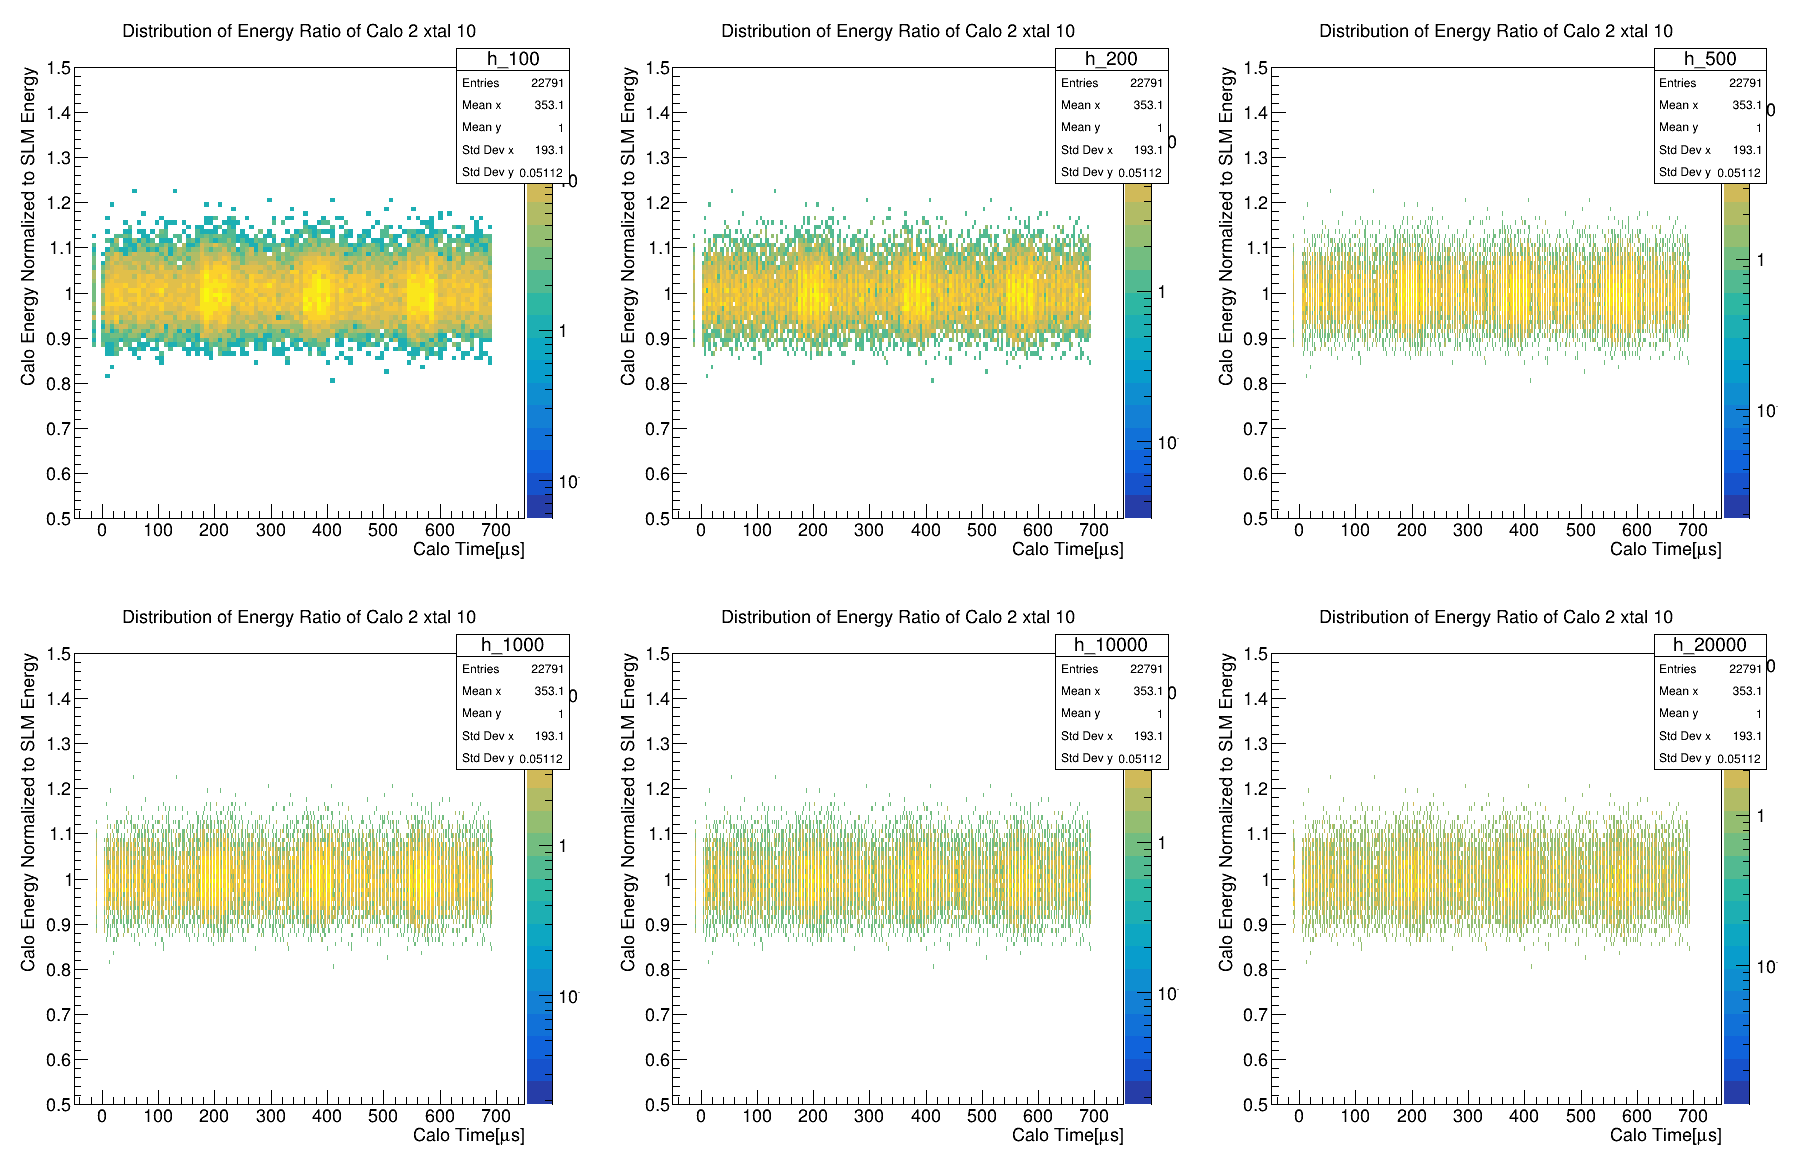

In [15]:
xbins = [100, 200, 500, 1000, 10000, 20000]
hists = [] #empty array to store histogram in
for xbin in xbins:
    h4 = r.TH2D("h_"+str(xbin), # name of the histogram in root
          "Distribution of Energy Ratio of Calo {} xtal {}; Calo Time[#mus]; Calo Energy Normalized to SLM Energy".format(calo,xtal), 
           xbin,-50,750,
           100,0.5,1.5 ) 

    for (x,y) in zip(laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/mean_temp):
        h4.Fill(1.25*x/1000,y)

    hists.append(h4.Clone("h_"+str(xbin))) 


c = r.TCanvas("c","c", 1800, 1200)
c.Divide(3,2) 
for i, h in enumerate(hists):
    c.cd(i+1) 
    h.Draw("colz")
    r.gPad.SetLogz() 
c.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


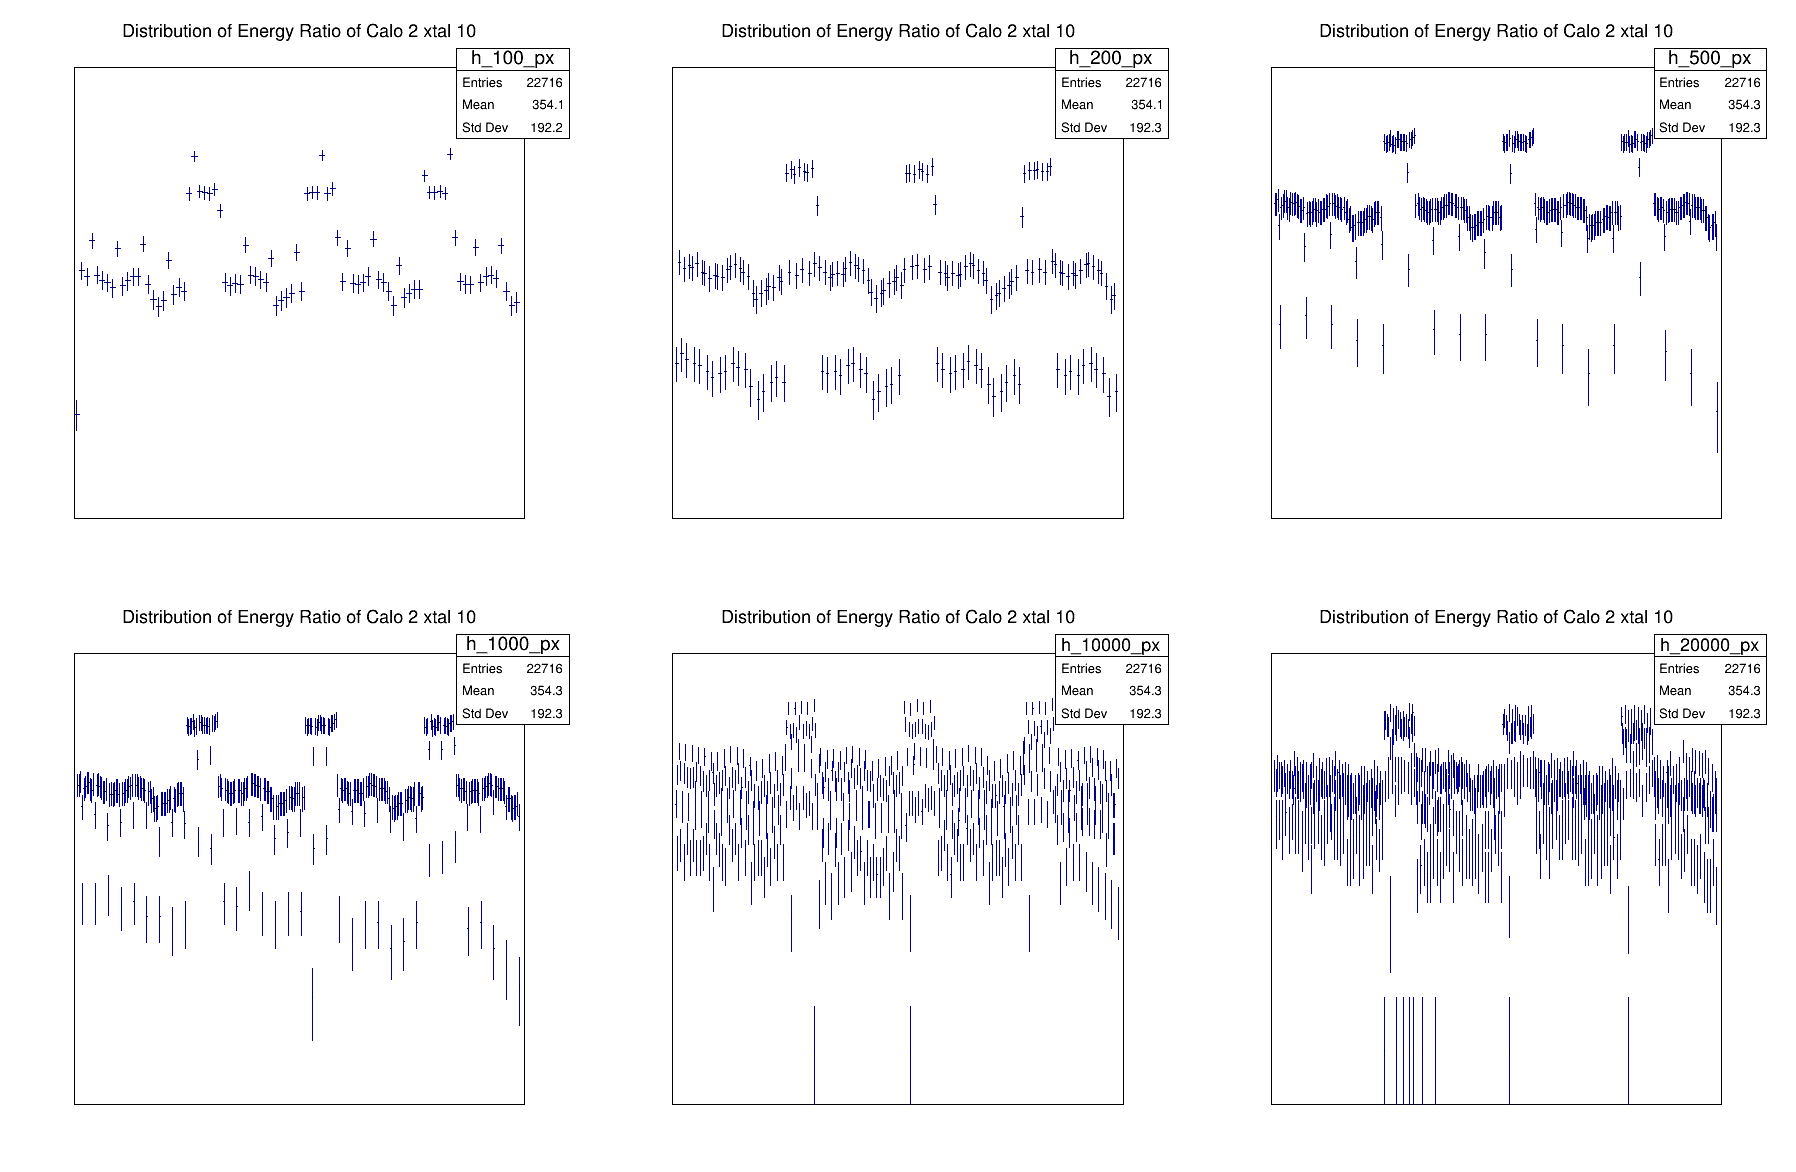

In [99]:

c = r.TCanvas("c","c", 1800, 1200) 
c.Divide(3,2) 
for i, h in enumerate(hists):
    c.cd(i+1) 
    h.GetXaxis().SetRangeUser(0,700)
    h.ProjectionX().Draw("mean") 
    r.gPad.SetLogy() 
c.Draw()

Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).


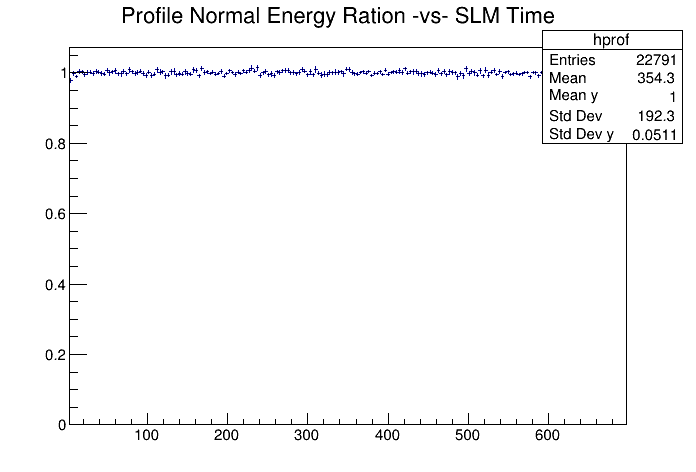

In [107]:
   means = np.zeros(200)
   errors = np.zeros(200)
   times = np.zeros(200)
   c2 = r.TCanvas()
   hprof = r.TProfile("hprof", "Profile Normal Energy Ration -vs- SLM Time",200, 2.5,697.5,0.5,1.5);
                        
                        
   for (x,y) in zip(laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/mean_temp):
        hprof.Fill(1.25*x/1000,y)
  
   hprof.Draw()
   c2.Draw()
   for j in range(200):
        means[j] = hprof.GetBinContent(j)
        errors[j] = hprof.GetBinError(j)
        times[j] = hprof.GetBinCenter(j)

In [101]:
times

array([ -1.75,   1.75,   5.25,   8.75,  12.25,  15.75,  19.25,  22.75,
        26.25,  29.75,  33.25,  36.75,  40.25,  43.75,  47.25,  50.75,
        54.25,  57.75,  61.25,  64.75,  68.25,  71.75,  75.25,  78.75,
        82.25,  85.75,  89.25,  92.75,  96.25,  99.75, 103.25, 106.75,
       110.25, 113.75, 117.25, 120.75, 124.25, 127.75, 131.25, 134.75,
       138.25, 141.75, 145.25, 148.75, 152.25, 155.75, 159.25, 162.75,
       166.25, 169.75, 173.25, 176.75, 180.25, 183.75, 187.25, 190.75,
       194.25, 197.75, 201.25, 204.75, 208.25, 211.75, 215.25, 218.75,
       222.25, 225.75, 229.25, 232.75, 236.25, 239.75, 243.25, 246.75,
       250.25, 253.75, 257.25, 260.75, 264.25, 267.75, 271.25, 274.75,
       278.25, 281.75, 285.25, 288.75, 292.25, 295.75, 299.25, 302.75,
       306.25, 309.75, 313.25, 316.75, 320.25, 323.75, 327.25, 330.75,
       334.25, 337.75, 341.25, 344.75, 348.25, 351.75, 355.25, 358.75,
       362.25, 365.75, 369.25, 372.75, 376.25, 379.75, 383.25, 386.75,
      

Slope: 3.737968130473863e-07
Standard Deviation: 0.0007499718944885948


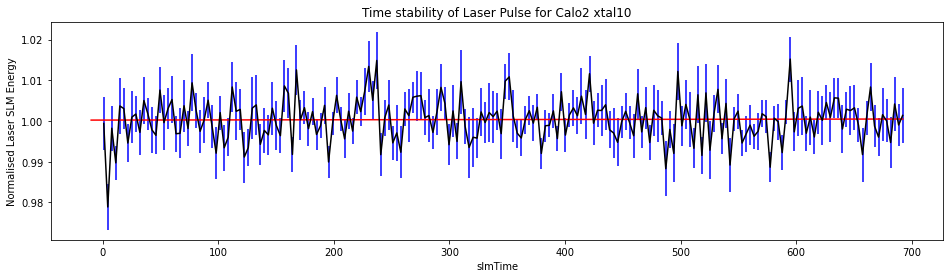

In [108]:
plt.figure(figsize=(16,4))
plt.errorbar(x= times, y = means, yerr = errors, ecolor = "blue", color = "black")
plt.title("Time stability of Laser Pulse for Calo{} xtal{}".format(calo,xtal))
plt.xlabel("slmTime")
plt.ylabel("Normalised Laser SLM Energy")
# fit a curve (linear for now) through the stability of time 

def func(x,m,b):
    return m*x + b 

initial_guess = [1.2, 0.03]
pars, pcov = curve_fit(func, times, means, p0=initial_guess)
xfit = np.linspace(np.amin(laserPulse['sipmTime'])*1.25/1000,np.amax(laserPulse['sipmTime'])*1.25/1000)
yfit = func(xfit, pars[0], pars[1])
plt.plot(xfit,yfit,'r-',label=f"Linear Fit\nm={pars[0]:.2f}\nb={pars[1]:.2f}")

print("Slope: {}".format(pars[0]))
print("Standard Deviation: {}".format(np.sqrt(pcov[1,1])))

In [110]:
#automation of the whole process to find out errors and time stabilities of all calo

timeGrowth = np.zeros((24,54))
timeStd = np.zeros((24,54))
timeErr = np.zeros((24,54))

for calo in pd.unique(df['caloNum'])[:14]:
    for xtal in  pd.unique(df['xtalNum']):

        df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
        syncPulse = df_xtal[df_xtal['slmTime']< -10000][['runNum','subRunNum','fillNum', 'slmEnergy']]
        laserPulse = df_xtal[df_xtal['slmTime']> -10000]

        syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
        laserPulse  = pd.merge(laserPulse,syncPulse, how = 'inner', on = ['runNum','subRunNum','fillNum'])
        laserPulse['normalSlmEnergy'] = (laserPulse['slmEnergy']/laserPulse['syncEnergy'])

        normalizingFactor = laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy'].mean()

        allmeans = np.zeros(200)
        allerrors = np.zeros(200)
        alltimes = np.zeros(200)  
        hprof = r.TProfile("hprof", "Profile Normal Energy Ratio -vs- SLM Time",200, 2.5,697.5,0.5,1.5);                    
                            
        for (x,y) in zip(laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/normalizingFactor):
            hprof.Fill(1.25*x/1000,y)

        for j in range(200):
            allmeans[j] = hprof.GetBinContent(j)
            allerrors[j] = hprof.GetBinError(j)
            alltimes[j] = hprof.GetBinCenter(j)

        def func(x,m,b):
            return m*x + b 

        initial_guess = [1.2, 0.03]
        pars, pcov = curve_fit(func, alltimes, allmeans, p0=initial_guess)

        timeGrowth[calo-1][xtal] = pars[0]
        timeStd[calo-1][xtal] = np.sqrt(pcov[1,1])
        timeErr[calo-1][xtal] = allerrors.max()

Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential me

In [111]:
#I just split this automation into two parts because it was giving some memort error for running all of it at once

for calo in pd.unique(df['caloNum'])[14:]:
    for xtal in  pd.unique(df['xtalNum']):

        df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
        syncPulse = df_xtal[df_xtal['slmTime']< -10000][['runNum','subRunNum','fillNum', 'slmEnergy']]
        laserPulse = df_xtal[df_xtal['slmTime']> -10000]

        syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
        laserPulse  = pd.merge(laserPulse,syncPulse, how = 'inner', on = ['runNum','subRunNum','fillNum'])
        laserPulse['normalSlmEnergy'] = (laserPulse['slmEnergy']/laserPulse['syncEnergy'])

        normalizingFactor = laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy'].mean()

        allmeans = np.zeros(200)
        allerrors = np.zeros(200)
        alltimes = np.zeros(200)  
        hprof = r.TProfile("hprof", "Profile Normal Energy Ratio -vs- SLM Time",200, 2.5,697.5,0.5,1.5);                    
                            
        for (x,y) in zip(laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/normalizingFactor):
            hprof.Fill(1.25*x/1000,y)

        for j in range(200):
            allmeans[j] = hprof.GetBinContent(j)
            allerrors[j] = hprof.GetBinError(j)
            alltimes[j] = hprof.GetBinCenter(j)

        def func(x,m,b):
            return m*x + b 

        initial_guess = [1.2, 0.03]
        pars, pcov = curve_fit(func, alltimes, allmeans, p0=initial_guess)

        timeGrowth[calo-1][xtal] = pars[0]
        timeStd[calo-1][xtal] = np.sqrt(pcov[1,1])
        timeErr[calo-1][xtal] = allerrors.max()

Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: hprof (Potential me

In [ ]:
for xtal in  pd.unique(df['xtalNum']):

    df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
    syncPulse = df_xtal[df_xtal['slmTime']< -10000][['runNum','subRunNum','fillNum', 'slmEnergy']]
    laserPulse = df_xtal[df_xtal['slmTime']> -10000]

    syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
    laserPulse  = pd.merge(laserPulse,syncPulse, how = 'inner', on = ['runNum','subRunNum','fillNum'])
    laserPulse['normalSlmEnergy'] = (laserPulse['slmEnergy']/laserPulse['syncEnergy'])

    normalizingFactor = laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy'].mean()

    allmeans = np.zeros(200)
    allerrors = np.zeros(200)
    alltimes = np.zeros(200)  
    hprof = r.TProfile("hprof", "Profile Normal Energy Ration -vs- SLM Time",200, 2.5,697.5,0.5,1.5);                    
                        
   for (x,y) in zip(laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/normalizingFactor):
        hprof.Fill(1.25*x/1000,y)
  
   for j in range(200):
        allmeans[j] = hprof.GetBinContent(j)
        allerrors[j] = hprof.GetBinError(j)
        alltimes[j] = hprof.GetBinCenter(j)

    def func(x,m,b):
        return m*x + b 

    initial_guess = [1.2, 0.03]
    pars, pcov = curve_fit(func, alltimes, allmeans, p0=initial_guess)

    timeGrowth[calo-1][xtal] = pars[0]
    timeStd[calo-1][xtal] = np.sqrt(pcov[1,1])
    timeErr[calo-1][xtal] = allerrors.max()

In [ ]:
##use profile_x for fitting

In [115]:
#timeGrowth is change of Energy Ratio per us (was in clock tick, coverted) 
fillTime = 700 # in us 
infill_RatioChange = timeGrowth*fillTime

Change of Energy Ratio during a fill scaled by 10000


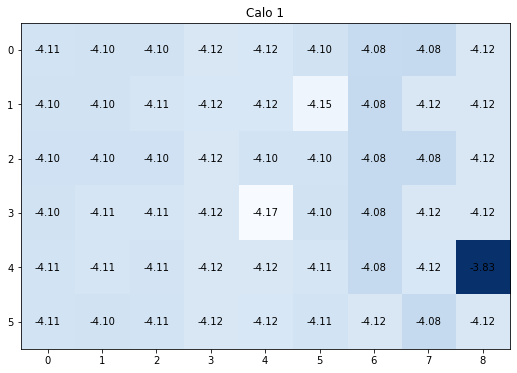

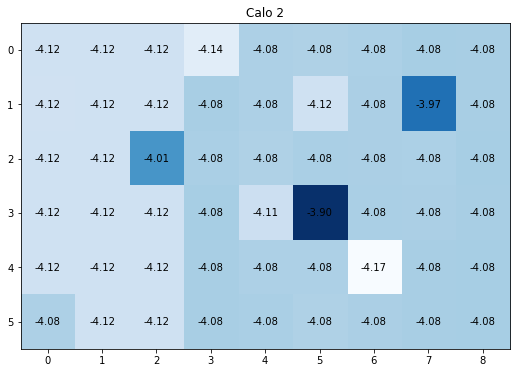

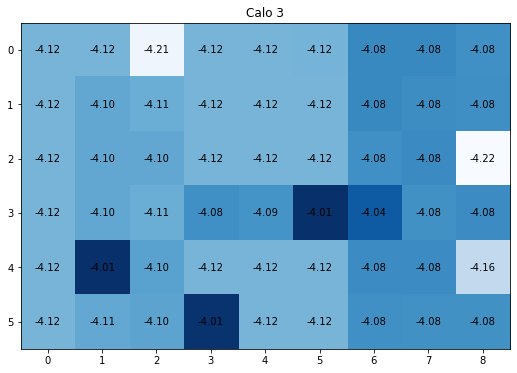

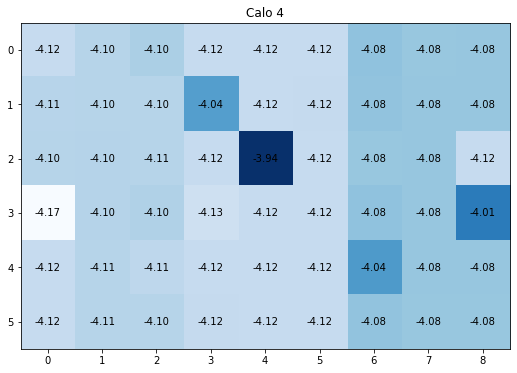

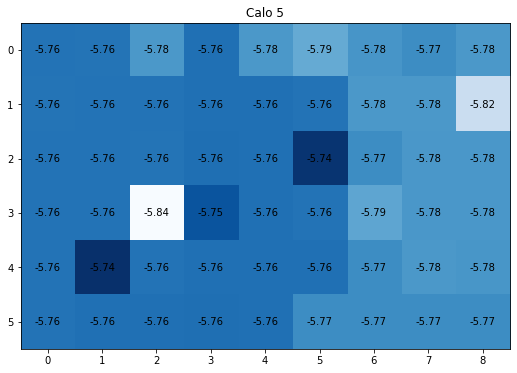

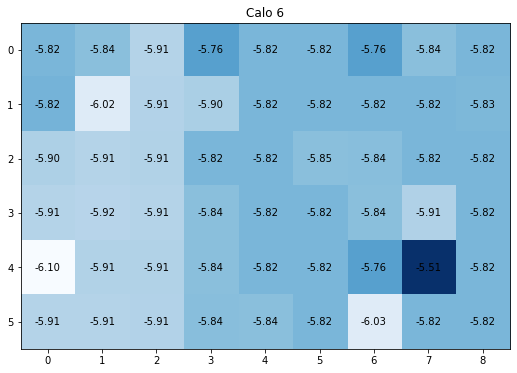

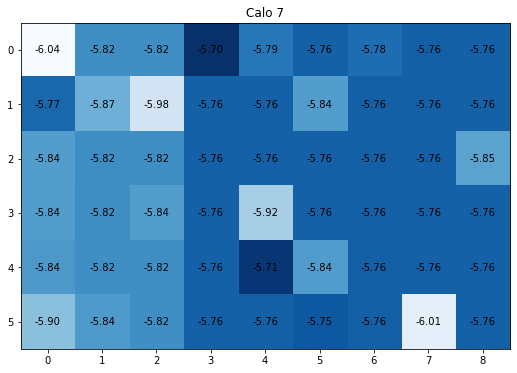

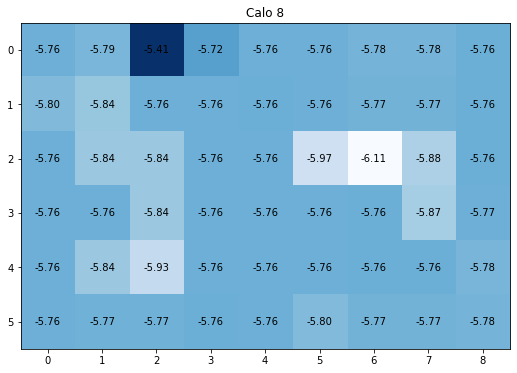

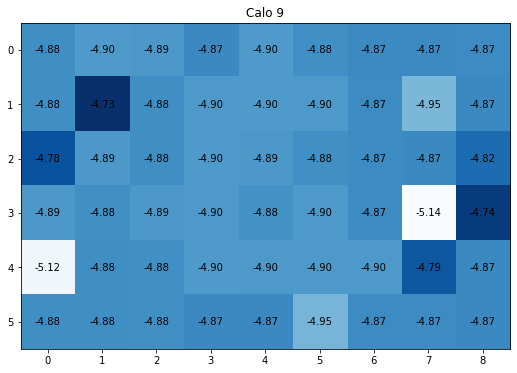

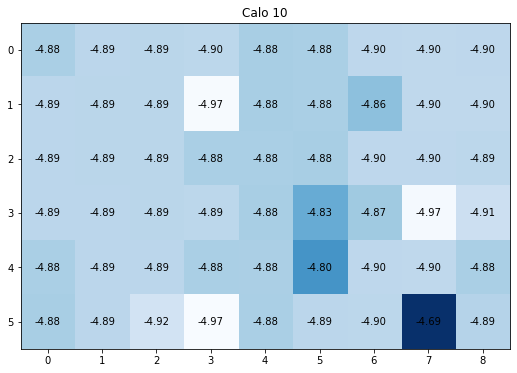

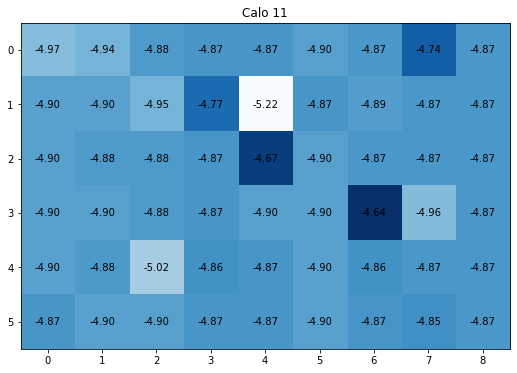

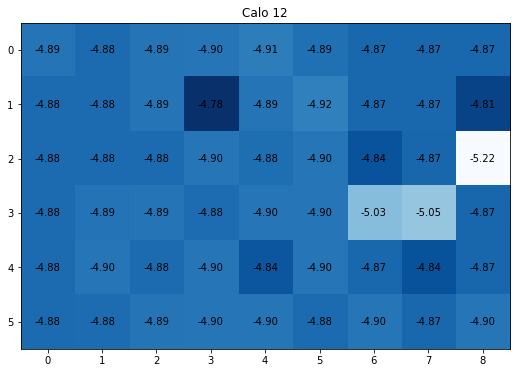

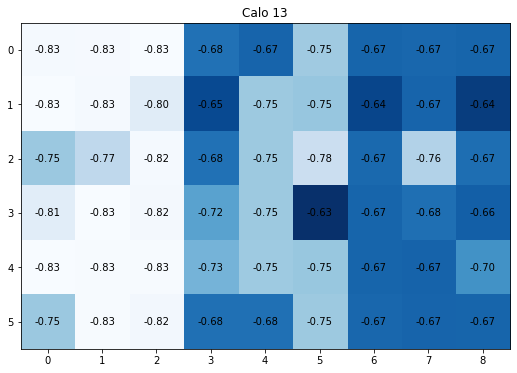

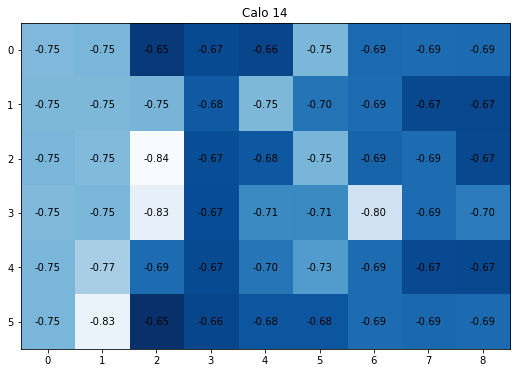

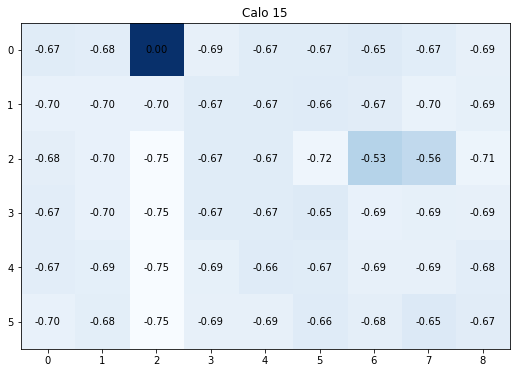

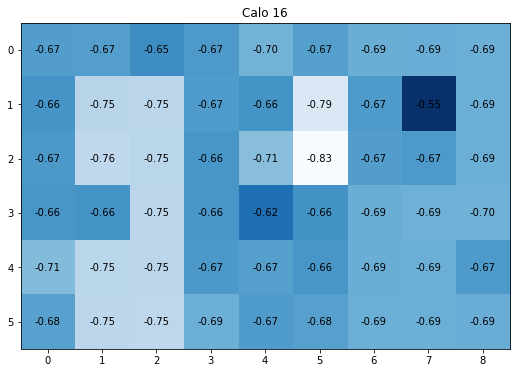

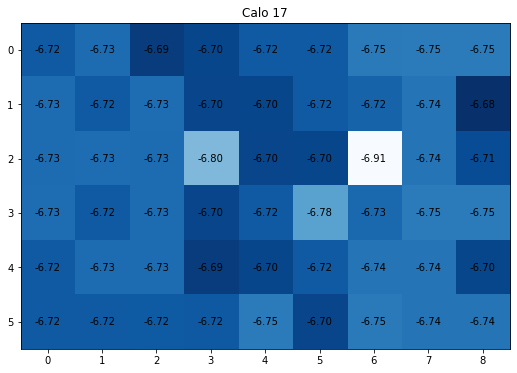

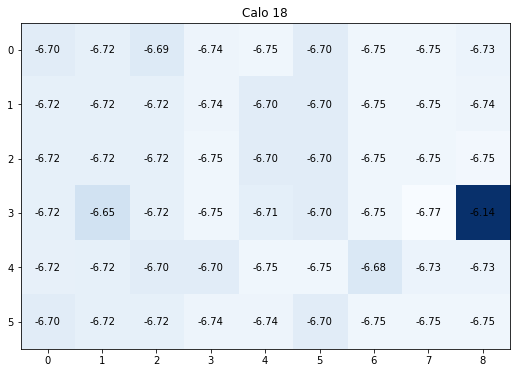

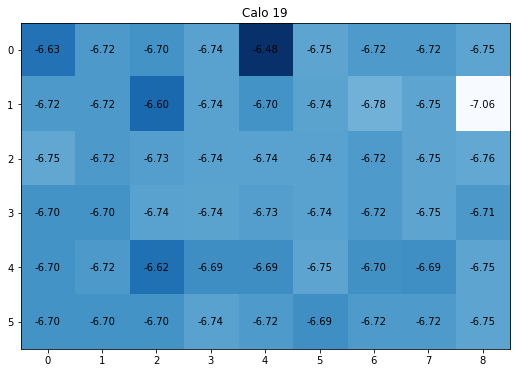

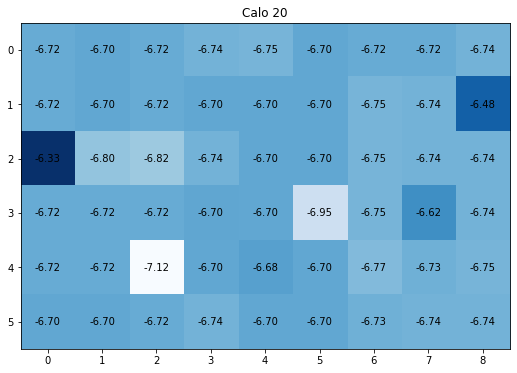

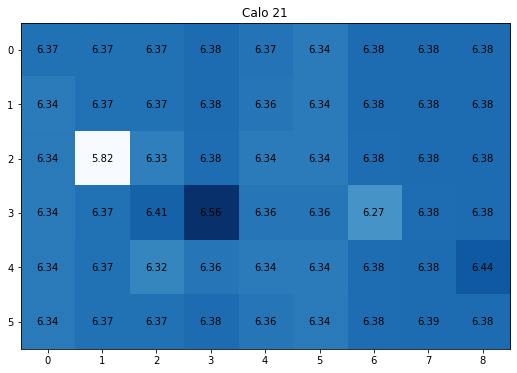

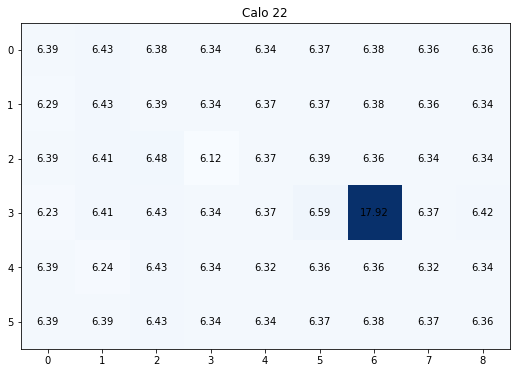

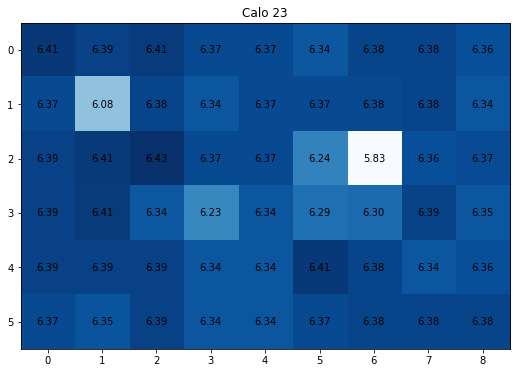

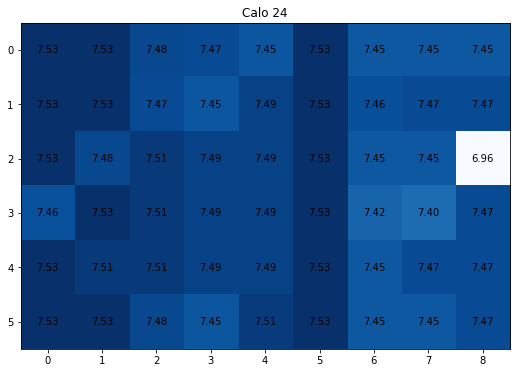

In [116]:
plt.rcParams["figure.figsize"] = (12,6) 
scale1 = (10**4)

print("Change of Energy Ratio during a fill scaled by {}".format(scale1))

for calo in pd.unique(df['caloNum']):
    fig,ax = plt.subplots()
    im = ax.imshow(infill_RatioChange[calo-1].reshape(6,9)*scale1,cmap=plt.cm.Blues)
    for i in range(6):
        for j in range(9):
            text = ax.text(j, i,"{0:.2f}".format(infill_RatioChange[calo-1].reshape(6,9)[i, j]*scale1),
                           ha="center", va="center", color="black")        
    plt.title('Calo {}'.format(calo))
    plt.show()
   

Error in Energy Ratio scaled by 10000


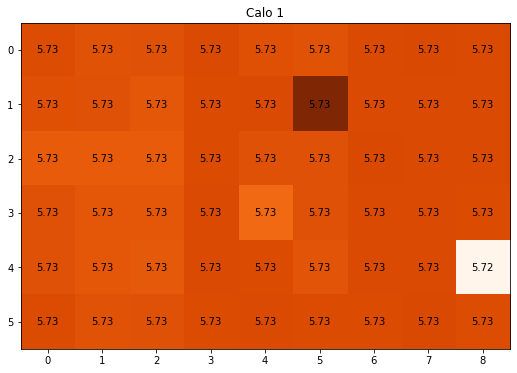

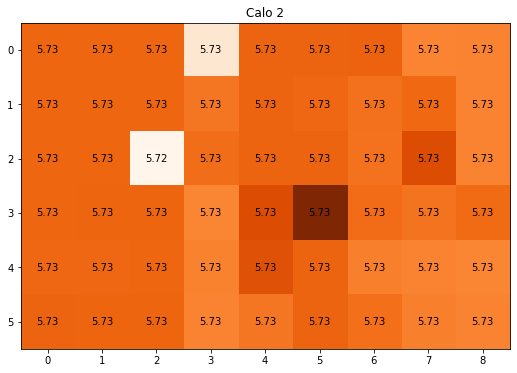

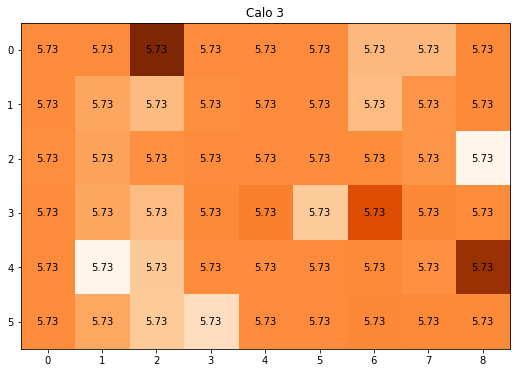

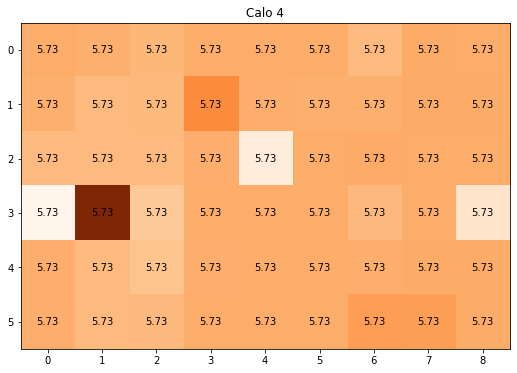

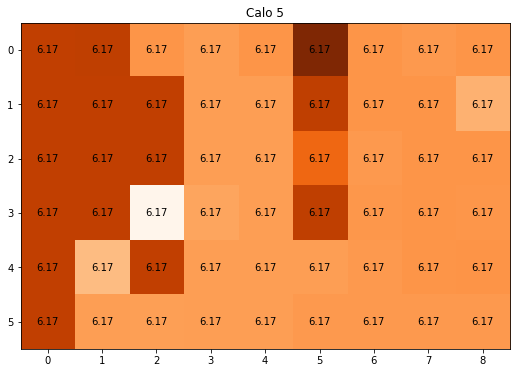

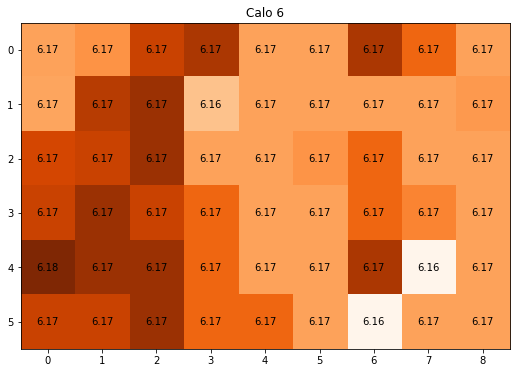

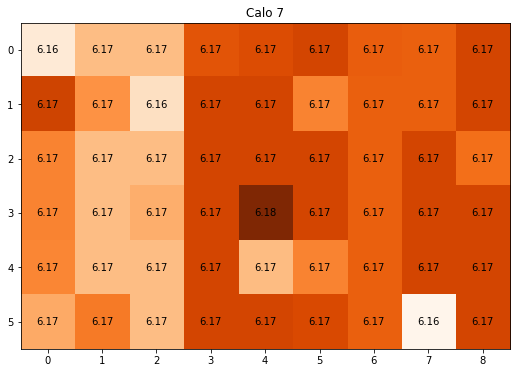

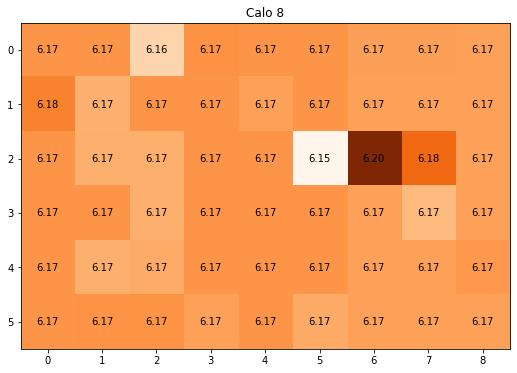

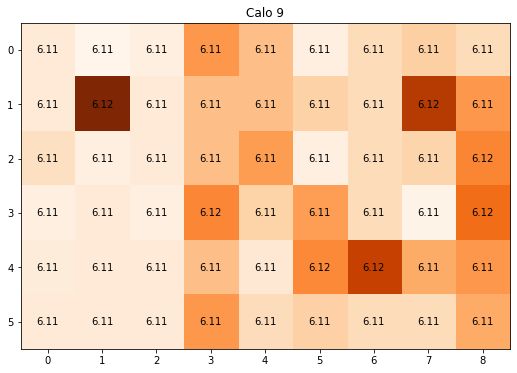

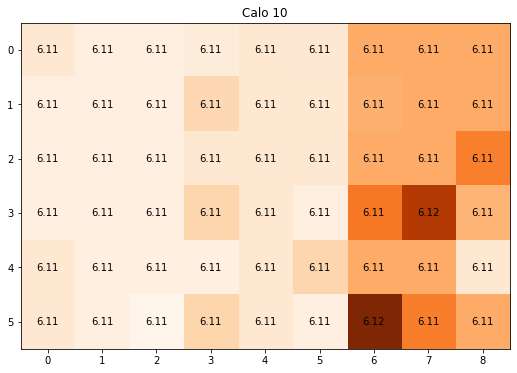

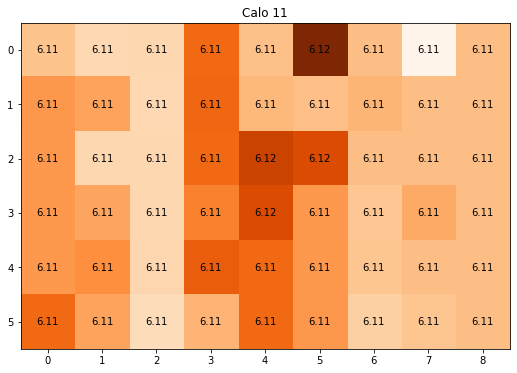

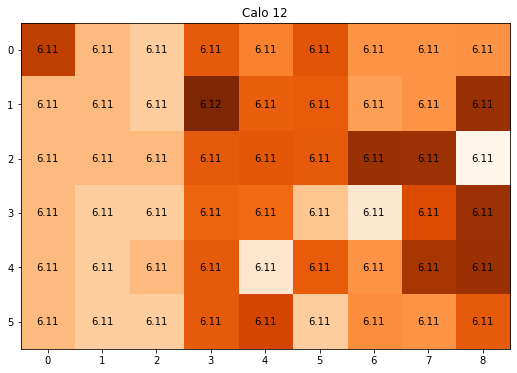

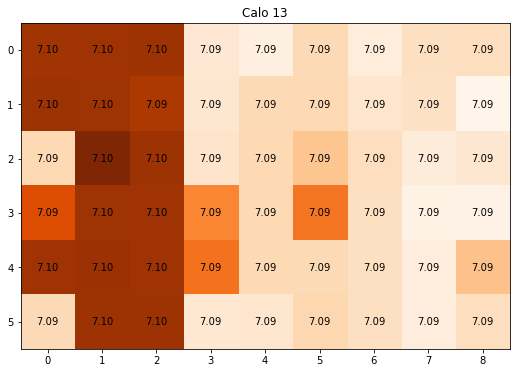

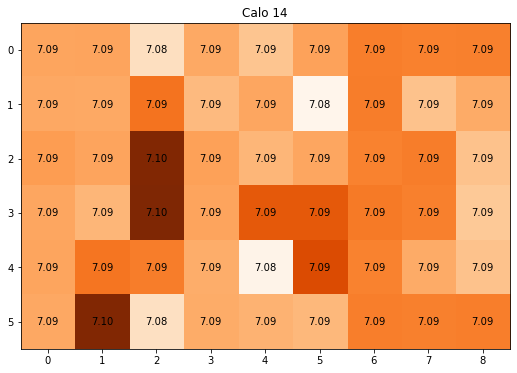

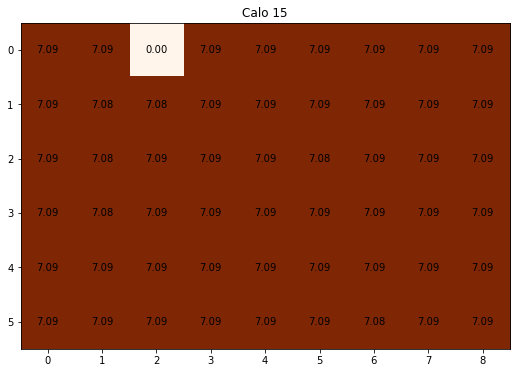

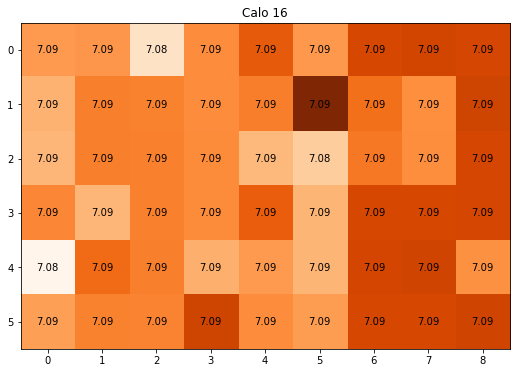

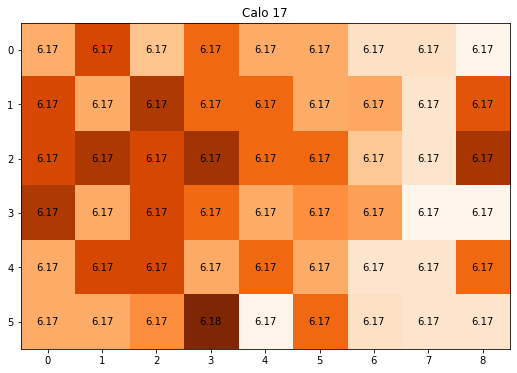

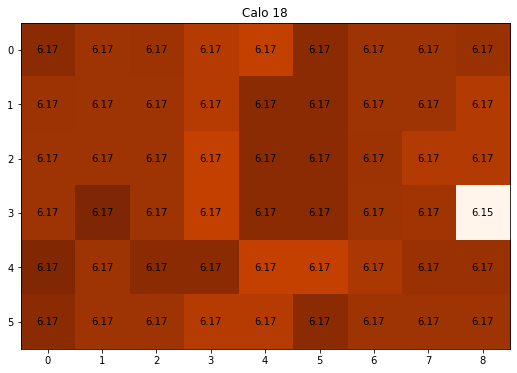

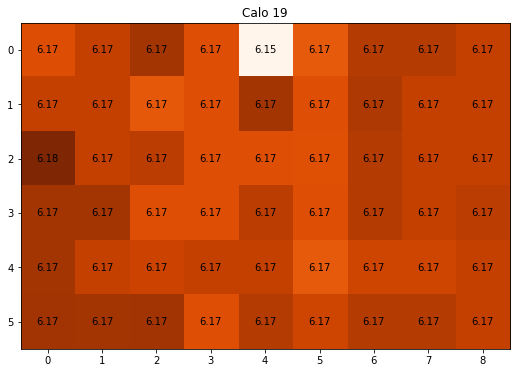

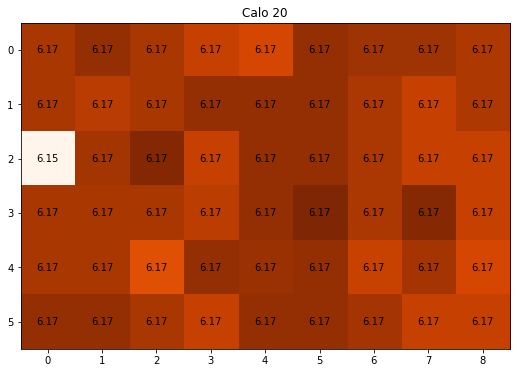

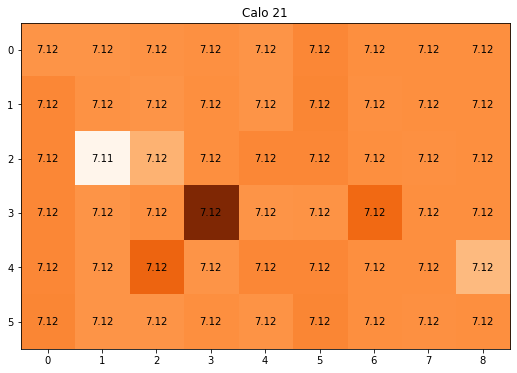

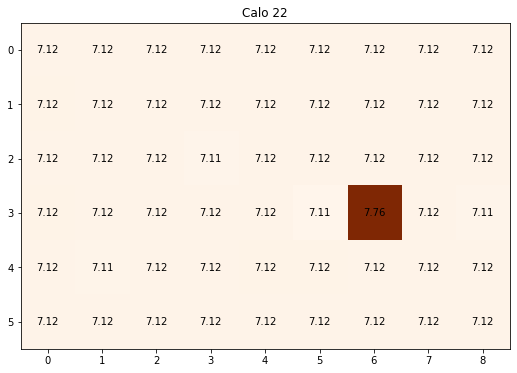

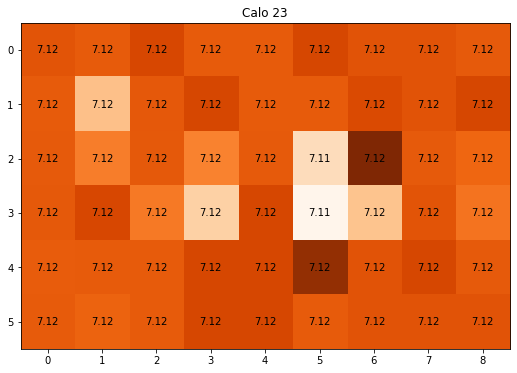

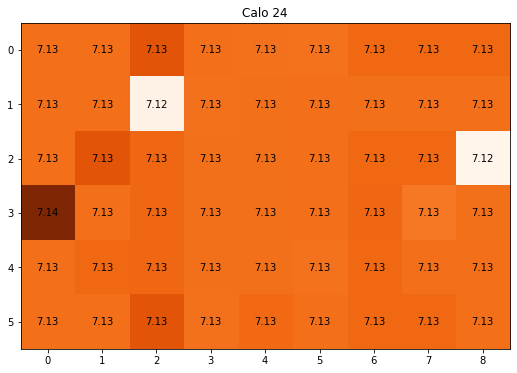

In [117]:
plt.rcParams["figure.figsize"] = (12,6) 

scale2 = (10**4)

print("Error in Energy Ratio scaled by {}".format(scale2))

for calo in pd.unique(df['caloNum']):
    fig,ax = plt.subplots()
    im = ax.imshow(timeStd[calo-1].reshape(6,9)*scale2,cmap=plt.cm.Oranges)
    for i in range(6):
        for j in range(9):
            text = ax.text(j, i,"{0:.2f}".format(timeStd[calo-1].reshape(6,9)[i, j]*scale2),
                           ha="center", va="center", color="black")        
    plt.title('Calo {}'.format(calo))
    plt.show()

In [119]:
caloAvgChange = np.zeros(24)
for calo in pd.unique(df['caloNum']):
    caloAvgChange[calo-1] = infill_RatioChange[calo-1].mean()
    
caloAvgError = np.zeros(24)
for calo in pd.unique(df['caloNum']):
    caloAvgError[calo-1] = timeStd[calo-1].max()

Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_5 (Potential memory leak).


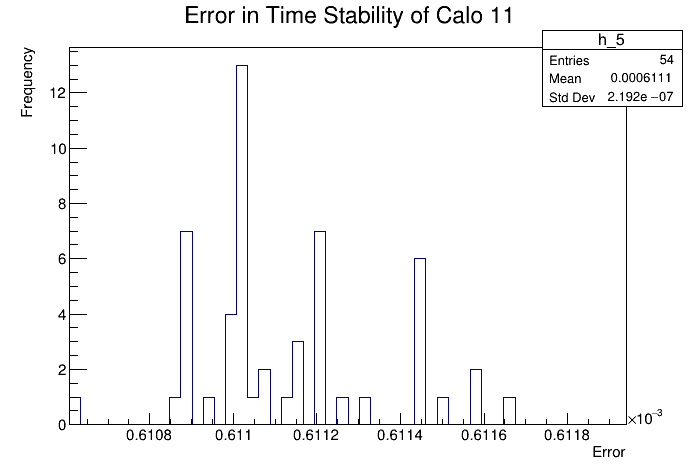

In [121]:
c3 =r.TCanvas()
calo = 11
h5 = r.TH1D(f"h_{5}", "Error in Time Stability of Calo {}; Error; Frequency".format(calo), 50, timeStd[calo-1].min(), timeStd[calo-1].max())

for x in timeStd[calo-1]:
    h5.Fill(x)

h5.Draw()
c3.Draw()

#semi  

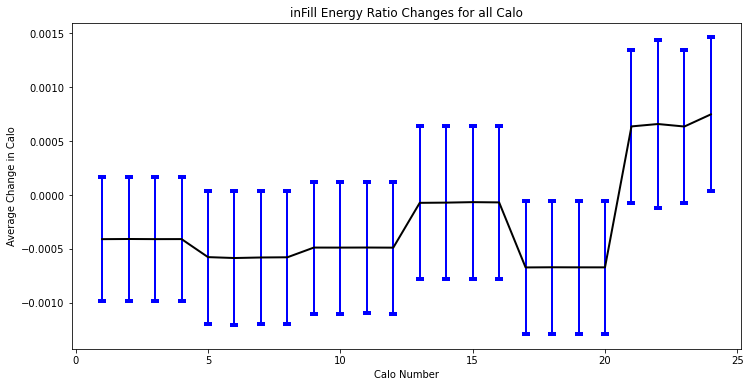

In [123]:
fig, ax = plt.subplots()

ax.errorbar(pd.unique(df['caloNum']), caloAvgChange, yerr= caloAvgError, lw = 2,capsize = 4, capthick = 4, ecolor = "blue", color = 'black')
plt.xlabel("Calo Number")
plt.ylabel("Average Change in Calo")
plt.title("inFill Energy Ratio Changes for all Calo")
plt.show()


In [70]:
infill_RatioChange[1][0]

-0.00023718786864490989